All libraries can be installed with pip besides prophet. Install using conda install -c conda-forge fbprophet

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import plotnine as pn
from plotnine import aes, ggplot
import pathlib
from datetime import datetime
import xlrd
from prophet import Prophet

# Import Datasets

Data from the following places will be used. I choose a to use only data from 2021-2023

- CPI (https://stats.oecd.org/index.aspx?DataSetCode=PRICES_CPI#)
- dollar (https://ru.investing.com/currencies/usd-zar-historical-data)
- petrol prices (https://www.energy.gov.za/files/esources/petroleum/petroleum_arch.html)

In [101]:
# get directory path
path = str(pathlib.Path().cwd().parent.parent.resolve())

In [102]:
cpi = pd.read_csv(path + '/data/PRICES_CPI_27052023151526761.csv')
dollar = pd.read_csv(path + '/data/DEXSFUS.csv')
# TODO: need to read in petrol prices (currently on a pdf)

# EDA
## View CPI

In [108]:
cpi_columns = {'Food and non-Alcoholic beverages' : 'Food', 
               'All items': 'CPI',
               'Alcoholic beverages, tobacco and narcotics': 'Alcohol',
               'Clothing and footwear': 'Clothes',
               'Housing, water, electricity, gas and other fuels': 'Household', 
               'Transport': 'Transport',
               'Recreation and culture': 'Recreation', 
               'Health': 'Health',
               'Furnishings, household equipment and routine household maintenance': 'Furnishings',
               'Communication': 'Communication',
               'Education': 'Education',
               'Restaurants and hotels': 'Restaurants', 
               'Miscellaneous goods and services': 'Other services'}

In [109]:
# Select only where measure in Index
cpi = cpi[cpi['Measure'] == 'National Index']

In [110]:
# get categories
cpi['cpi_cat'] = cpi['Subject'].apply(lambda x: x.split('- ')[-1])
cpi = cpi[cpi['cpi_cat'].isin(cpi_columns)][['Time', 'cpi_cat', 'Value']]

/var/folders/gx/c35dzbl95sg3t62y03g1j6s40000gn/T/ipykernel_12894/1604307784.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [111]:
# change month to datetime format
cpi['Date'] = pd.to_datetime(cpi['Time']).dt.strftime('%Y-%m')

/var/folders/gx/c35dzbl95sg3t62y03g1j6s40000gn/T/ipykernel_12894/3347956333.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


In [112]:
# map categories to shorter names
cpi = cpi.replace(cpi_columns)

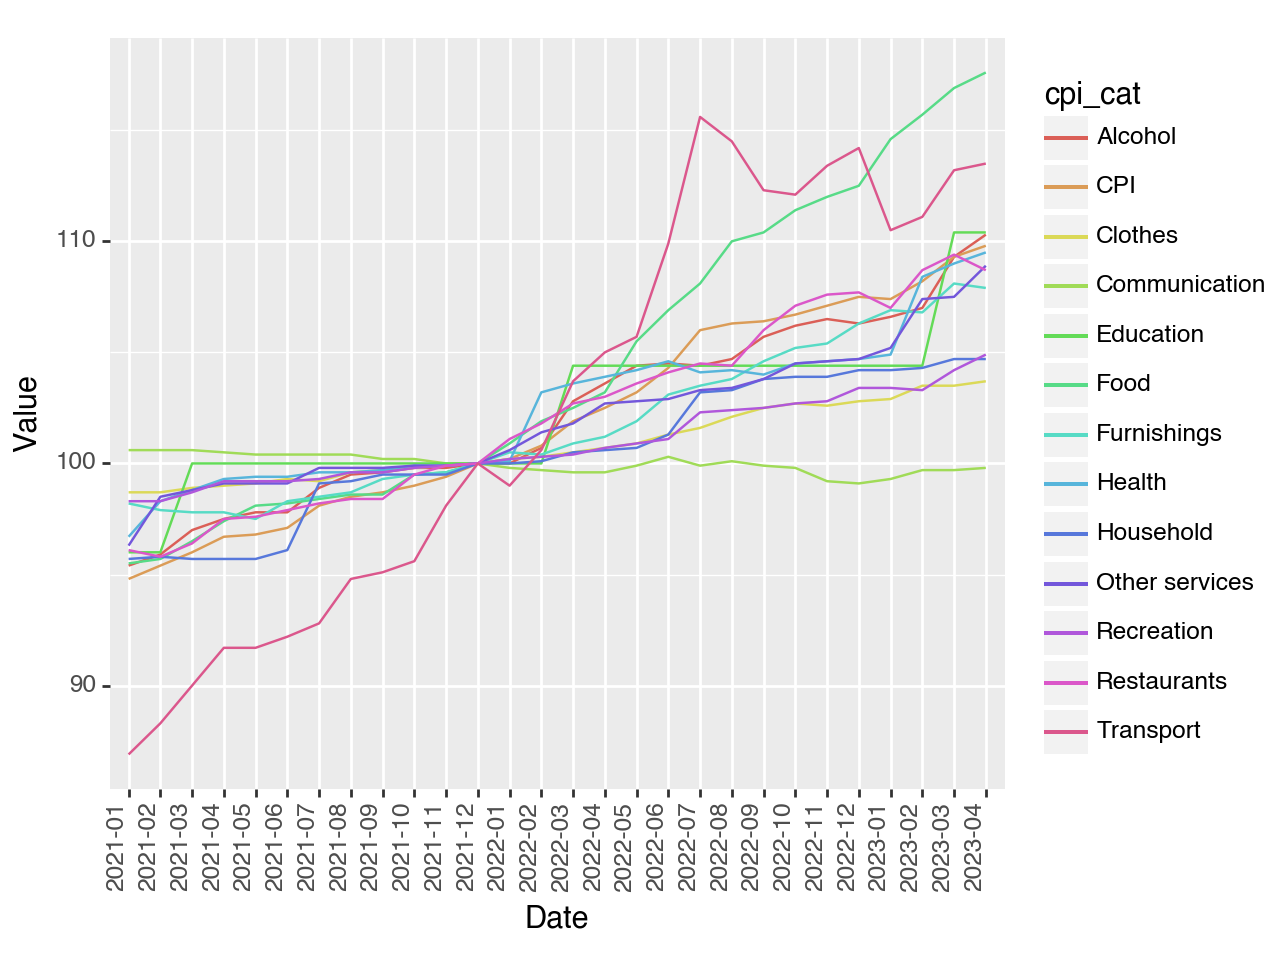

<Figure Size: (640 x 480)>

In [113]:
(ggplot(cpi) + 
pn.geom_line(aes(x='Date', y='Value', color='cpi_cat', group='cpi_cat')) + 
pn.theme(axis_text_x=pn.element_text(rotation=90, hjust=1)))

## Prophet model

## ALL CPI 

In [117]:
def train_predict_prophet(cpi, cat, pred_date):
    df = cpi[cpi['cpi_cat'] == cat]
    df = df[['Date', 'Value']]
    df.columns = ['ds', 'y']

    model = Prophet()
    model.fit(df)

    df_pred = pd.DataFrame({'ds':[pred_date]})
    df_pred['ds'] = pd.to_datetime(df_pred['ds'])

    df_model_pred = model.predict(df_pred)
    df_model_pred['cat'] = cat

    return df_model_pred


In [118]:
df_prophet_pred = []
for cat in cpi_columns.values():
    df_prophet_pred.append(train_predict_prophet(cpi=cpi, cat=cat, pred_date='30-Mar-2023'))

15:27:24 - cmdstanpy - INFO - Chain [1] start processing
15:27:53 - cmdstanpy - INFO - Chain [1] done processing
15:27:53 - cmdstanpy - INFO - Chain [1] start processing
15:28:21 - cmdstanpy - INFO - Chain [1] done processing
15:28:21 - cmdstanpy - INFO - Chain [1] start processing
15:28:44 - cmdstanpy - INFO - Chain [1] done processing
15:28:44 - cmdstanpy - INFO - Chain [1] start processing
15:29:12 - cmdstanpy - INFO - Chain [1] done processing
15:29:12 - cmdstanpy - INFO - Chain [1] start processing
15:29:40 - cmdstanpy - INFO - Chain [1] done processing
15:29:40 - cmdstanpy - INFO - Chain [1] start processing
15:30:10 - cmdstanpy - INFO - Chain [1] done processing
15:30:10 - cmdstanpy - INFO - Chain [1] start processing
15:30:38 - cmdstanpy - INFO - Chain [1] done processing
15:30:39 - cmdstanpy - INFO - Chain [1] start processing
15:31:06 - cmdstanpy - INFO - Chain [1] done processing
15:31:07 - cmdstanpy - INFO - Chain [1] start processing
15:31:36 - cmdstanpy - INFO - Chain [1]

In [119]:
df_pred_all = pd.concat(df_prophet_pred)

In [120]:
df_pred_all.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,cat
0,2023-03-30,120.524915,110.710125,110.710125,120.524915,120.524915,-9.814790,-9.814790,-9.814790,-9.814790,-9.814790,-9.814790,0.0,0.0,0.0,110.710125,Food
0,2023-03-30,108.948679,111.031288,111.031288,108.948679,108.948679,2.082609,2.082609,2.082609,2.082609,2.082609,2.082609,0.0,0.0,0.0,111.031288,CPI
0,2023-03-30,109.500240,110.839039,110.839039,109.500240,109.500240,1.338798,1.338798,1.338798,1.338798,1.338798,1.338798,0.0,0.0,0.0,110.839039,Alcohol
0,2023-03-30,103.351468,107.877130,107.877130,103.351468,103.351468,4.525662,4.525662,4.525662,4.525662,4.525662,4.525662,0.0,0.0,0.0,107.877130,Clothes
0,2023-03-30,105.447467,104.594044,104.594044,105.447467,105.447467,-0.853423,-0.853423,-0.853423,-0.853423,-0.853423,-0.853423,0.0,0.0,0.0,104.594044,Household


# Get submission file

In [121]:
df_sub = df_pred_all[['cat', 'trend']]
df_sub.columns = ['ID', 'Value']

In [122]:
month = 'May'

In [123]:
pred_map = {'CPI': f'{month}_headline CPI',
'Alcohol': f'{month}_alcoholic beverages and tobacco',
'Clothes': f'{month}_clothing and footwear',
'Communication': f'{month}_communication',
'Education': f'{month}_education',
'Food': f'{month}_food and non-alcoholic beverages',
'Health': f'{month}_health',
'Furnishings': f'{month}_household contents and services',
'Household': f'{month}_housing and utilities',
'Other services': f'{month}_miscellaneous goods and services',
'Recreation': f'{month}_recreation and culture',
'Restaurants': f'{month}_restaurants and hotels',
'Transport': f'{month}_transport'}

In [124]:
df_sub = df_sub.replace(pred_map)

In [125]:
df_sub.to_csv(path + '/submissions/v1_prophet.csv', index=False)